In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Tratamento do DF e criação de colunas importantes

In [2]:
# Valores históricos dos dados para o grupo 1
df = pd.read_excel('DadosG1.xlsx')
df["Valor"] = df["Valor"].str.replace(",",".")
df = df.reset_index(drop=True)
df["Data Coleta"] = pd.to_datetime(df["Data Coleta"], format="%d/%m/%Y")

cols = [
    "Valor",
    "Data Coleta",
    "Parametro",
    "Unidade"
]

params = [
    'pH',
    'Temperatura da Água',
    'Escherichia coli**',
    'Temperatura do Ar',
    'Turbidez',
    'Nitrogênio Kjeldahl',
    'Nitrogênio-Nitrito',
    'Nitrogênio-Nitrato',
    'Oxigênio Dissolvido',
    'Sólido Total',
    'Fósforo Total',
]

conversao_O2 = {
    0: 14.6,
    1: 14.2,
    2: 13.8,
    3: 13.5,
    4: 13.1,
    5: 12.8,
    6: 12.5,
    7: 12.2,
    8: 11.9,
    9: 11.6, 
    10: 11.3,
    11: 11.1,
    12: 10.9,
    13: 10.6,
    14: 10.4,
    15: 10.2,
    16: 10.0,
    17: 9.8,
    18: 9.6,
    19: 9.4,
    20: 9.2,
    21: 9.0,
    22: 8.9,
    23: 8.7,
    24: 8.6,
    25: 8.4,
    26: 8.2,
    27: 8.1,
    28: 7.9,
    29: 7.8,
    30: 7.7
}

In [3]:
# Transforma os valores em float
data = df.loc[df['Parametro'].isin(params), cols]
data['Valor'] = data['Valor'].astype(float)

#####################################################################################################################################

# Cálculo do oxigênio dissolvido
df_oxigenio = data.loc[data["Parametro"] == "Oxigênio Dissolvido", cols]
ox_mgL_series = pd.Series(df_oxigenio['Valor']).reset_index(drop=True)

df_temp = data.loc[data["Parametro"] == "Temperatura da Água", cols].reset_index(drop=True)
temp_agua_series = pd.Series(df_temp['Valor']).reset_index(drop=True)

ox_porcentagem = []

for i, conc_atual in enumerate(ox_mgL_series):
    temp_agua = temp_agua_series[i]

    floating = float(temp_agua) - int(float(temp_agua))

    if (floating > 0.5):
        temp_agua = int(float(temp_agua)) + 1
    else:
        temp_agua = int(float(temp_agua))

    conc_sat = conversao_O2[temp_agua]

    ox_porcentagem.append((conc_atual/conc_sat)*100)

ox_porc = pd.DataFrame()
ox_porc['Data Coleta'] = df_oxigenio['Data Coleta']
ox_porc['Valor'] = ox_porcentagem
ox_porc['Parametro'] = 'Oxigênio Dissolvido'
ox_porc['Unidade'] = '%'

data.loc[data['Parametro'] == 'Oxigênio Dissolvido', 'Parametro'] = 'Oxigênio Dissolvido MGL'
data = data.merge(ox_porc, how='outer')

In [4]:
# Cálculo do Nitrogênio Total
data_nitrogenio = data.loc[data['Parametro'].isin(['Nitrogênio Kjeldahl', 'Nitrogênio-Nitrito','Nitrogênio-Nitrato'])]

nitrogenio_list = data_nitrogenio.groupby(['Data Coleta'])['Valor'].sum()
nitrogenio = pd.DataFrame()
nitrogenio['Data Coleta'] = nitrogenio_list.index
nitrogenio['Valor'] = nitrogenio_list.values
nitrogenio['Parametro'] = 'Nitrogênio Total'
nitrogenio['Unidade'] = 'mg/L'

data.drop(data.loc[data['Parametro'].isin(['Nitrogênio Kjeldahl', 'Nitrogênio-Nitrito','Nitrogênio-Nitrato'])].index, inplace=True)
data = data.merge(nitrogenio, how='outer')

In [5]:
# Cálculo do delta de temperatura
delta_temperatura = data.loc[data['Parametro'].isin(['Temperatura da Água', 'Temperatura do Ar']), ['Data Coleta', 'Parametro', 'Valor', 'Unidade']]

df_pivot = delta_temperatura.pivot(index="Data Coleta", columns="Parametro", values="Valor")

df_pivot.columns = ["Temperatura da Água", "Temperatura do Ar"]
df_pivot["Delta Temperatura"] = df_pivot["Temperatura do Ar"] - df_pivot["Temperatura da Água"]
df_pivot['Unidade'] = '°C'
df_pivot['Parametro'] = 'Delta Temperatura'
df_pivot = df_pivot.rename(columns={'Delta Temperatura': 'Valor'})
df_pivot = df_pivot[['Parametro', 'Valor', 'Unidade']]
df_pivot.reset_index(inplace=True)

data.drop(data.loc[data['Parametro'].isin(['Temperatura da Água', 'Temperatura do Ar'])].index, inplace=True)
data = data.merge(df_pivot, how='outer')

In [6]:
# Cálculo dos Coliformes Termotolerantes
data.loc[data['Parametro'] == 'Escherichia coli**', 'Valor'] = data.loc[data['Parametro'] == 'Escherichia coli**', 'Valor'] * 1.25
data.loc[data['Parametro'] == 'Escherichia coli**', 'Parametro'] = 'Coliformes Termotolerantes'

# Junção final do DF
data.sort_values(['Parametro', 'Data Coleta'], inplace=True)
data = data[['Data Coleta', 'Parametro', 'Valor', 'Unidade']]

In [7]:
data['Parametro'].unique()

array(['Coliformes Termotolerantes', 'Delta Temperatura', 'Fósforo Total',
       'Nitrogênio Total', 'Oxigênio Dissolvido',
       'Oxigênio Dissolvido MGL', 'Sólido Total', 'Turbidez', 'pH'],
      dtype=object)

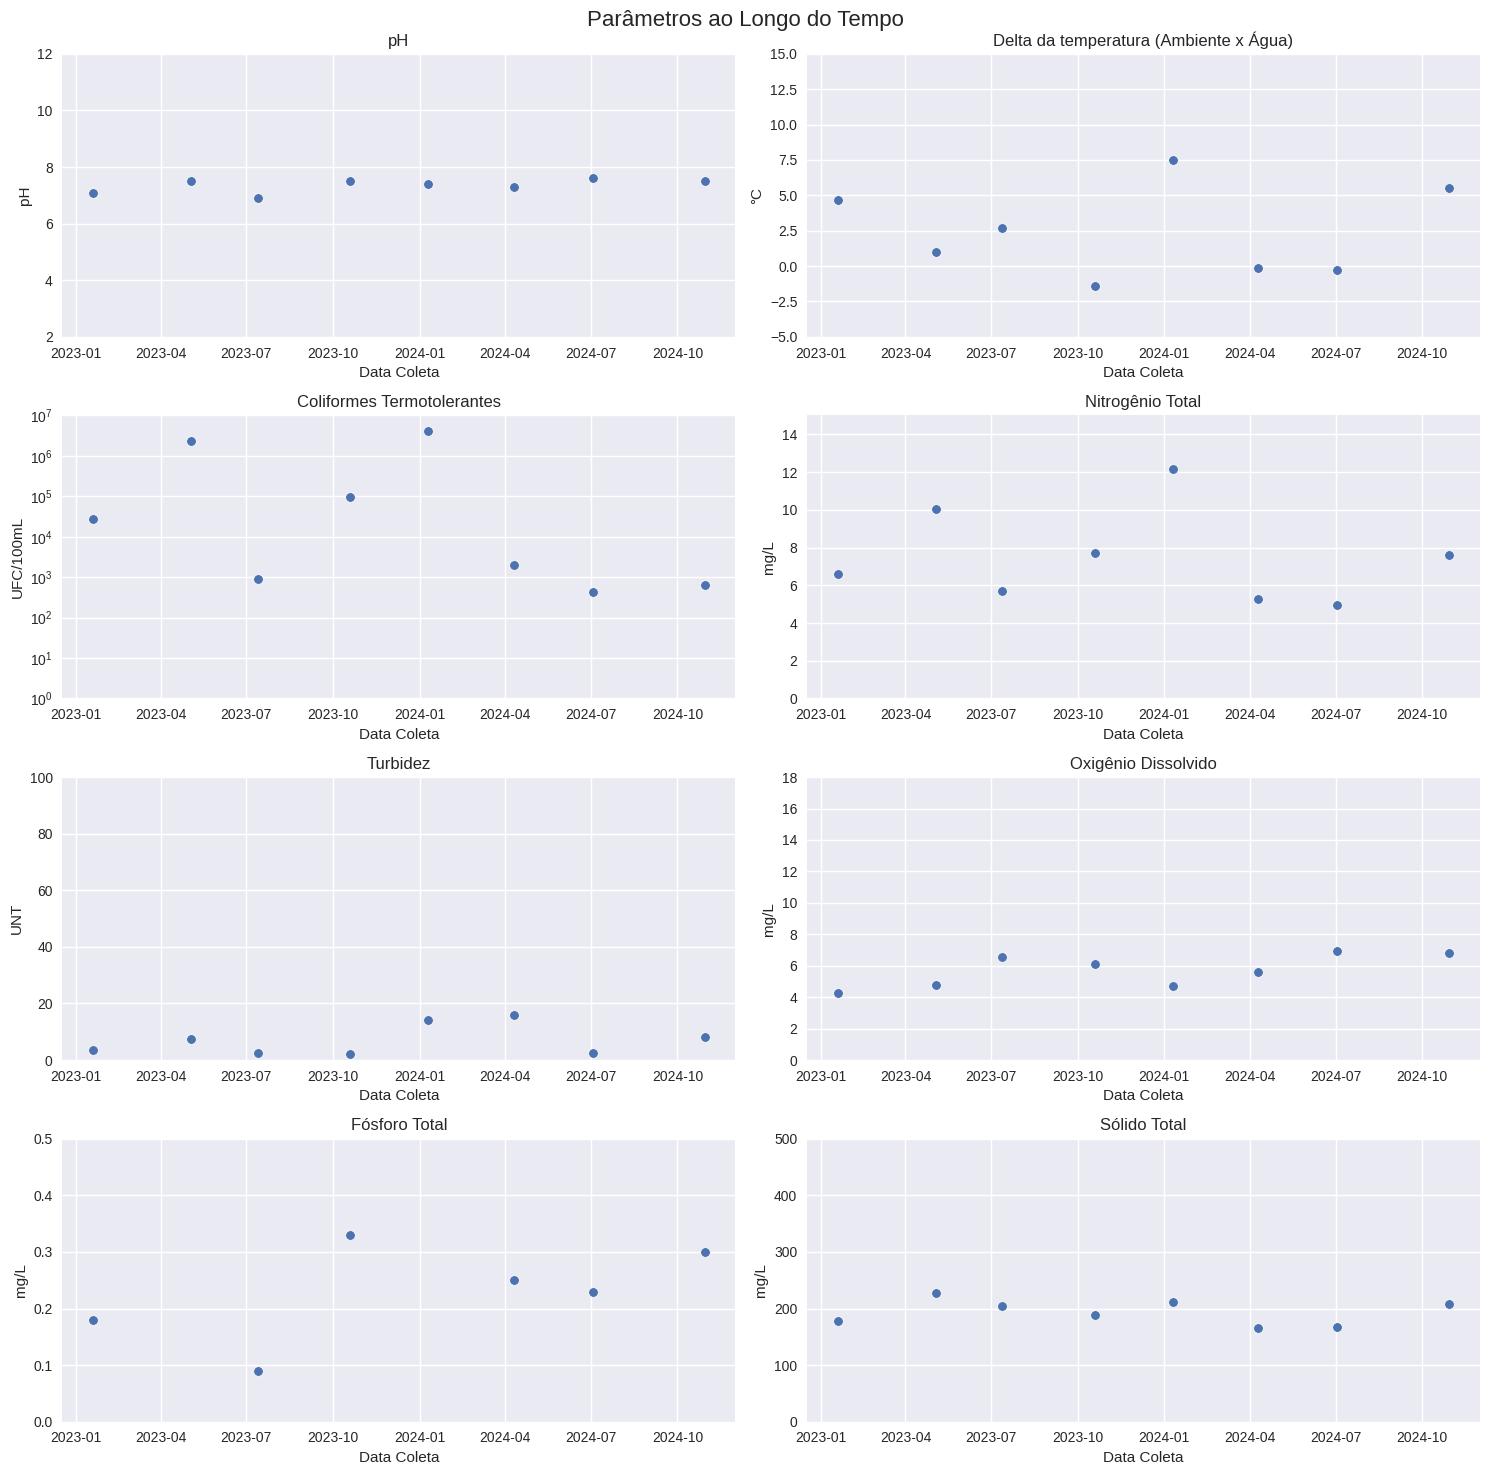

In [8]:
#Gráficos dos dados históricos:
plt.style.use('seaborn-v0_8')
fig, axes = plt.subplots(4, 2, figsize=(15, 15))
fig.suptitle('Parâmetros ao Longo do Tempo', size=16)

# Plot 1: pH
sns.scatterplot(data=data[data['Parametro']=='pH'], 
            x='Data Coleta', y='Valor', 
            marker='o', ax=axes[0,0])
axes[0,0].set_title('pH')
axes[0,0].set_ylabel('pH')
axes[0,0].set_ylim(2, 12)

# Plot 2: Temperatura
temp_data = data[data['Parametro'].isin(['Delta Temperatura'])]
sns.scatterplot(data=temp_data, x='Data Coleta', y='Valor', marker='o', ax=axes[0,1])
axes[0,1].set_title('Delta da temperatura (Ambiente x Água)')
axes[0,1].set_ylabel('°C')
axes[0,1].set_ylim(-5, 15)

# Plot 3: Coliformes (log scale due to large range)
sns.scatterplot(data=data[data['Parametro']=='Coliformes Termotolerantes'], 
            x='Data Coleta', y='Valor', 
            marker='o', ax=axes[1,0])
axes[1,0].set_yscale('log')
axes[1,0].set_title('Coliformes Termotolerantes')
axes[1,0].set_ylabel('UFC/100mL')
axes[1,0].set_ylim(1, 10000000)

# Plot 4: Nitrogênio Total
sns.scatterplot(data=data[data['Parametro']=='Nitrogênio Total'], 
            x='Data Coleta', y='Valor', 
            marker='o', ax=axes[1,1])
axes[1,1].set_title('Nitrogênio Total')
axes[1,1].set_ylabel('mg/L')
axes[1,1].set_ylim(0, 15)

# Plot 5: Turbidez
sns.scatterplot(data=data[data['Parametro']=='Turbidez'], 
            x='Data Coleta', y='Valor', 
            marker='o', ax=axes[2,0])
axes[2,0].set_title('Turbidez')
axes[2,0].set_ylabel('UNT')
axes[2,0].set_ylim(0, 100)

# Plot 6: Oxigênio Dissolvido
sns.scatterplot(data=data[data['Parametro']=='Oxigênio Dissolvido MGL'], 
            x='Data Coleta', y='Valor', 
            marker='o', ax=axes[2,1])
axes[2,1].set_title('Oxigênio Dissolvido')
axes[2,1].set_ylabel('mg/L')
axes[2,1].set_ylim(0, 18)

# Plot 7: Fósforo total
sns.scatterplot(data=data[data['Parametro']=='Fósforo Total'], 
            x='Data Coleta', y='Valor', 
            marker='o', ax=axes[3,0])
axes[3,0].set_title('Fósforo Total')
axes[3,0].set_ylabel('mg/L')
axes[3,0].set_ylim(0, 0.5)

# Plot 8: Sólido total
sns.scatterplot(data=data[data['Parametro']=='Sólido Total'], 
            x='Data Coleta', y='Valor', 
            marker='o', ax=axes[3,1])
axes[3,1].set_title('Sólido Total')
axes[3,1].set_ylabel('mg/L')
axes[3,1].set_ylim(0, 500)


plt.tight_layout()
plt.show()

In [9]:
# Cálculo do IQA (Índice de Qualidade da Água)
iqa_file = pd.ExcelFile('DadosIQA.xlsx')

# Relação dos arquivos de base para cálcudo do IQA com a nossa tabela criada
iqa_data = {
    'pH': {
        'name': 'pH',
        'lim_inf': [2, 2],
        'lim_sup': [12, 3],
        'q': [],
        'peso': 0.12
    },
    'Delta Temperatura': {
        'name': 'Temperatura',
        'lim_inf': [-5, np.inf],
        'lim_sup': [15, 9],
        'q': [],
        'peso': 0.10
    },
    'Coliformes Termotolerantes': {
        'name': 'Coliformes',
        'lim_inf': [1, 100],
        'lim_sup': [1e5, 3],
        'q': [],
        'peso': 0.15
    },
    'Nitrogênio Total': {
        'name': 'N',
        'lim_inf': [0.5, 100],
        'lim_sup': [100, 1],
        'q': [],
        'peso': 0.10
    },
    'Turbidez': {
        'name': 'Turbidez',
        'lim_inf': [0.5, 100],
        'lim_sup': [100, 5],    
        'q': [],
        'peso': 0.08
    },
    'Oxigênio Dissolvido': {
        'name': 'OD',
        'lim_inf': [5, 5],
        'lim_sup': [140, 47],
        'q': [],
        'peso': 0.17
    },
    'Fósforo Total': {
        'name':'Fosforo',
        'lim_inf': [0.5, 100],
        'lim_sup': [10, 5],
        'q': [],
        'peso': 0.10
    },
    'Sólido Total': {
        'name': 'Residuos',
        'lim_inf': [0, 83],
        'lim_sup': [500, 32],
        'q': [],
        'peso': 0.08
    }
}

In [10]:
# Loop para calcular os Q's de cada parâmetro
x = data['Parametro'].unique()
x = np.delete(x, 5)

for param in x:
    data_per_param = data.loc[data['Parametro'] == param]
    iqa_df = pd.read_excel(iqa_file, iqa_data[param]['name'])
    
    for val in data_per_param['Valor']:
        if val < iqa_data[param]['lim_inf'][0]:
            q = iqa_data[param]['lim_inf'][1]
        elif val > iqa_data[param]['lim_sup'][0]:
            q = iqa_data[param]['lim_sup'][1]
        else:
            for index in range(1, len(iqa_df[iqa_df.columns[0]])):
                if val <= iqa_df[iqa_df.columns[0]][index]:
                    q = np.interp(val, 
                                    [float(iqa_df[iqa_df.columns[0]][index]), float(iqa_df[iqa_df.columns[0]][index-1])], 
                                    [iqa_df[iqa_df.columns[1]][index], iqa_df[iqa_df.columns[1]][index-1]])
                    break

        iqa_data[param]['q'].append(float(f'{q:.4f}'))

for param in iqa_data.keys():
    print(f'Valores de q para {param}: {iqa_data[f"{param}"]["q"]}')

Valores de q para pH: [90.0, 93.4694, 87.1429, 93.4694, 93.4694, 92.2449, 93.0612, 93.4694]
Valores de q para Delta Temperatura: [49.6939, 92.1429, 72.8571, 82.7551, 30.0, 91.2245, 91.2245, 43.6735]
Valores de q para Coliformes Termotolerantes: [4.9528, 3.0, 19.8113, 2.1226, 3.0, 15.0943, 26.4151, 22.8774]
Valores de q para Nitrogênio Total: [61.7843, 52.3302, 63.1158, 55.9254, 47.004, 65.3795, 66.9774, 56.9907]
Valores de q para Turbidez: [75.674, 75.674, 75.674, 75.674, 68.8408, 66.7453, 75.674, 75.674]
Valores de q para Oxigênio Dissolvido: [39.6617, 39.6617, 69.3802, 69.3802, 49.8995, 59.6407, 79.6162, 79.6162]
Valores de q para Fósforo Total: [100.0, 46.0, 100.0, 100.0, 55.2, 100.0, 100.0, 100.0]
Valores de q para Sólido Total: [77.0055, 71.3187, 74.2857, 77.0055, 73.0494, 78.7363, 78.7363, 73.0494]


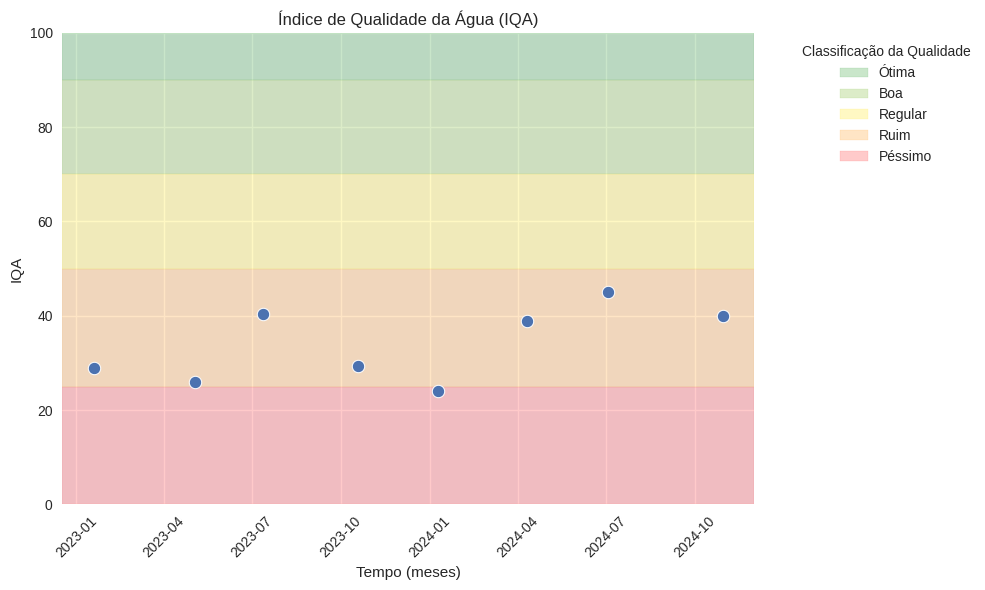

In [11]:
# Pesos dos parâmetros
pesos = np.array([iqa_data[param]['peso'] for param in iqa_data])

# Valores de qualidade (q) para cada amostra
q_values = np.array([iqa_data[param]['q'] for param in iqa_data])

IQA = np.prod(q_values**pesos[:, None], axis=0)
df_iqa = pd.DataFrame()

df_iqa['Data'] = data['Data Coleta'].unique()
df_iqa['IQA'] = IQA

# Plotting IQA over time
plt.figure(figsize=(10, 6))

# Define quality bands
bands = [
    {'min': 90, 'max': 100, 'color': '#4CAF50', 'label': 'Ótima'},     # Dark green
    {'min': 70, 'max': 90, 'color': '#8BC34A', 'label': 'Boa'},        # Light green
    {'min': 50, 'max': 70, 'color': '#FFEB3B', 'label': 'Regular'},    # Yellow
    {'min': 25, 'max': 50, 'color': '#FFAB40', 'label': 'Ruim'},       # Orange
    {'min': 0, 'max': 25, 'color': '#FF5252', 'label': 'Péssimo'}      # Red
]

# Add colored bands to the background
for band in bands:
    plt.axhspan(band['min'], band['max'], alpha=0.3, color=band['color'], label=band['label'])

# Plot the data points using your existing code
sns.scatterplot(data=df_iqa, x='Data', y='IQA', marker='o', s=80)
# Add line connecting points

plt.title('Índice de Qualidade da Água (IQA)')
plt.xlabel('Tempo (meses)')
plt.ylabel('IQA')
plt.ylim(0, 100)
plt.grid(True)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Classificação da Qualidade')

# Improve x-axis date formatting if needed
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

# Nossos dados

In [12]:
# Cálculo do IQA da nossa amostra (Índice de Qualidade da Água)
data = pd.read_csv('nossos_dados.csv')
iqa_file = pd.ExcelFile('DadosIQA.xlsx')

# Relação dos arquivos de base para cálcudo do IQA com a nossa tabela criada
iqa_data = {
    'pH': {
        'name': 'pH',
        'lim_inf': [2, 2],
        'lim_sup': [12, 3],
        'q': [],
        'peso': 0.12
    },
    'Temperatura': {
        'name': 'Temperatura',
        'lim_inf': [-5, np.inf],
        'lim_sup': [15, 9],
        'q': [],
        'peso': 0.10
    },
    'Coliformes Termotolerantes': {
        'name': 'Coliformes',
        'lim_inf': [1, 100],
        'lim_sup': [1e5, 3],
        'q': [],
        'peso': 0.15
    },
    'Nitrogênio Total': {
        'name': 'N',
        'lim_inf': [0.5, 100],
        'lim_sup': [100, 1],
        'q': [],
        'peso': 0.10
    },
    'Turbidez': {
        'name': 'Turbidez',
        'lim_inf': [0.5, 100],
        'lim_sup': [100, 5],    
        'q': [],
        'peso': 0.08
    },
    'Oxigênio Dissolvido': {
        'name': 'OD',
        'lim_inf': [5, 5],
        'lim_sup': [140, 47],
        'q': [],
        'peso': 0.17
    },
    'Fósforo Total': {
        'name':'Fosforo',
        'lim_inf': [0.5, 100],
        'lim_sup': [10, 5],
        'q': [],
        'peso': 0.10
    },
    'Sólido Total': {
        'name': 'Residuos',
        'lim_inf': [0, 83],
        'lim_sup': [500, 32],
        'q': [],
        'peso': 0.08
    }
}

In [13]:
# Loop para calcular os Q's de cada parâmetro
for param in iqa_data.keys():
    data_per_param = data.loc[data['Parametro'] == param]
    iqa_df = pd.read_excel(iqa_file, iqa_data[param]['name'])

    for val in data_per_param['Valor']:
        if val < iqa_data[param]['lim_inf'][0]:
            q = iqa_data[param]['lim_inf'][1]
        elif val > iqa_data[param]['lim_sup'][0]:
            q = iqa_data[param]['lim_sup'][1]
        else:
            for index in range(1, len(iqa_df[iqa_df.columns[0]])):
                if val <= iqa_df[iqa_df.columns[0]][index]:
                    q = np.interp(val, 
                                    [float(iqa_df[iqa_df.columns[0]][index]), float(iqa_df[iqa_df.columns[0]][index-1])], 
                                    [iqa_df[iqa_df.columns[1]][index], iqa_df[iqa_df.columns[1]][index-1]])
                    break

        iqa_data[param]['q'].append(float(f'{q:.4f}'))

In [14]:
for param in iqa_data.keys():
    print(f'Valor de q para {param}: {iqa_data[f"{param}"]["q"]}')

Valor de q para pH: [69.3878]
Valor de q para Temperatura: [88.9796]
Valor de q para Coliformes Termotolerantes: [3.0]
Valor de q para Nitrogênio Total: [54.8602]
Valor de q para Turbidez: [44.9704]
Valor de q para Oxigênio Dissolvido: [29.6785]
Valor de q para Fósforo Total: [55.2]
Valor de q para Sólido Total: [32.0]


In [15]:
# Pesos dos parâmetros
pesos = np.array([iqa_data[param]['peso'] for param in iqa_data])

# Valores de qualidade (q) para cada amostra
q_values = np.array([iqa_data[param]['q'] for param in iqa_data])

IQA = np.prod(q_values**pesos[:, None], axis=0)
IQA = IQA * 3**0.1

df_iqa2 = pd.DataFrame()

df_iqa2.loc[0, 'Data'] = pd.to_datetime('2025-02-25', format='%Y-%m-%d')
df_iqa2.loc[0, 'IQA'] = IQA

df_iqa = df_iqa.merge(df_iqa2, how='outer')

In [16]:
IQA

array([24.33572273])

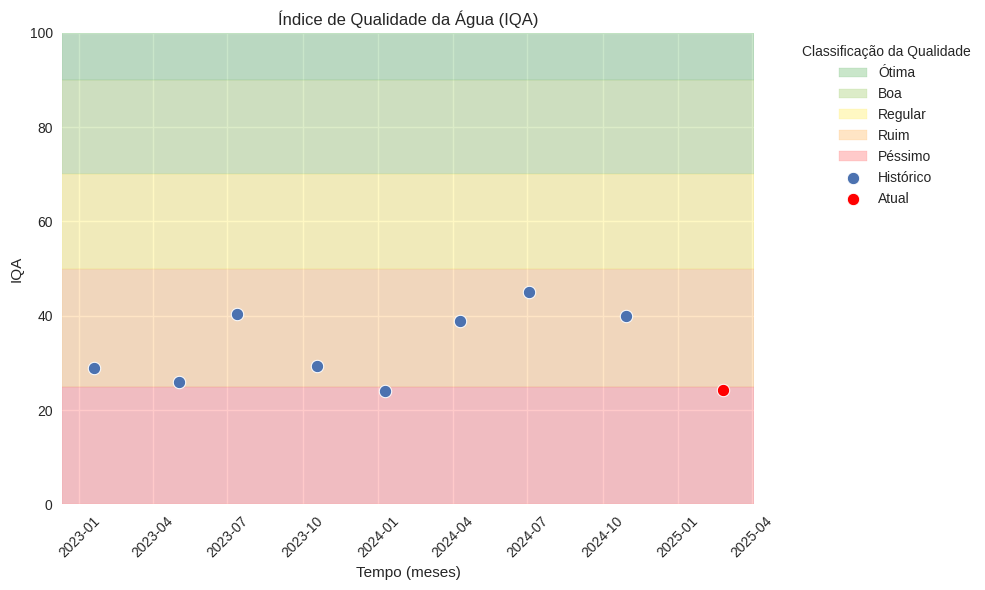

In [19]:
# Plotting IQA over time
plt.figure(figsize=(10, 6))

# Define quality bands
bands = [
    {'min': 90, 'max': 100, 'color': '#4CAF50', 'label': 'Ótima'},     # Dark green
    {'min': 70, 'max': 90, 'color': '#8BC34A', 'label': 'Boa'},        # Light green
    {'min': 50, 'max': 70, 'color': '#FFEB3B', 'label': 'Regular'},    # Yellow
    {'min': 25, 'max': 50, 'color': '#FFAB40', 'label': 'Ruim'},       # Orange
    {'min': 0, 'max': 25, 'color': '#FF5252', 'label': 'Péssimo'}      # Red
]

# Add colored bands to the background
for band in bands:
    plt.axhspan(band['min'], band['max'], alpha=0.3, color=band['color'], label=band['label'])

# Plot the data points
sns.scatterplot(data=df_iqa.iloc[:-1], x='Data', y='IQA', marker='o', s=80, label='Histórico')
sns.scatterplot(data=df_iqa.iloc[-1:], x='Data', y='IQA', marker='o', s=80, color='red', label='Atual')

plt.title('Índice de Qualidade da Água (IQA)')
plt.xlabel('Tempo (meses)')
plt.ylabel('IQA')
plt.ylim(0, 100)
plt.grid(True)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Classificação da Qualidade')

# Improve x-axis date formatting if needed
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()
